# Introduction

Since this dataset is small about (3000 photos), it will be difficult for our model to learn patterns within the photos with few data points.<br>
With that being said, I'm going to use the concept of **Transfer Learning** to train the model to get really accurate results.
<br>
Transfer learning allows us to use pre-trained models that have done all the extensive, and time-consuming training on large datasets and reuse them for similar tasks. 

---

# Importing Libraries

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [21]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

---

# Transfer Learning

Deep convolutional neural network models may result in some long training times.

Too short-cut this process is to re-use the model weights from pre-trained models that were developed for standard computer vision benchmark datasets, such as the ImageNet image recognition tasks. Top performing models can be downloaded and used directly, or integrated into a new model for your own computer vision problems.

I'll start with the **EfficientNetB0** model which will use the weights from the **ImageNet** dataset. 
If time is permitted will compare with other pre-trained models

In [12]:
from tensorflow.keras.applications import EfficientNetB0

effnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(150,150,3))

**GlobalAveragePooling2D** : Similar to Max Pooling, uses the Average values instead of the Max value while *pooling*. This really decrease the computational load during training
<br><br>
**Dropout** : Excludes some neurons at each step from the layer making the neurons more independent from the neighbouring neurons. It helps in avoiding overfitting. Neurons to be excluded are selected at random. The **rate** parameter is the likelihood of a neuron activation being set to 0, thus dropping out the neuron

**Dense** : Output layer which classifies the image into 1 of the 4 possible classes.

In [13]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4, activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv_1 (TFOpLambda)  (None, 150, 150, 3)  0          ['normalization[0][0]']      

In [15]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

**Callbacks** -> Callbacks can help you fix bugs more quickly, and can help you build better models. They can help you visualize how your model’s training is going, and can even help prevent overfitting by implementing early stopping or customizing the learning rate on each iteration.<br><br>
By definition, "A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training."

In this notebook, I'll be using **TensorBoard, ModelCheckpoint and ReduceLROnPlateau** callback functions

In [16]:
checkpoint = ModelCheckpoint("effnet_model.h5", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto', verbose=1)

---

# Training The Model

In [17]:
X_train = np.load('../saves/data/x_train.npy')
y_train = np.load('../saves/data/y_train.npy')

In [18]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[checkpoint,reduce_lr])

Epoch 1/12
74/74 [==============================] - ETA: 0s - loss: 0.5162 - accuracy: 0.8101
Epoch 1: val_accuracy improved from -inf to 0.78244, saving model to effnet_model.h5
74/74 [==============================] - 136s 2s/step - loss: 0.5162 - accuracy: 0.8101 - val_loss: 0.8586 - val_accuracy: 0.7824 - lr: 0.0010
Epoch 2/12
74/74 [==============================] - ETA: 0s - loss: 0.2116 - accuracy: 0.9289
Epoch 2: val_accuracy improved from 0.78244 to 0.87405, saving model to effnet_model.h5
74/74 [==============================] - 129s 2s/step - loss: 0.2116 - accuracy: 0.9289 - val_loss: 0.5569 - val_accuracy: 0.8740 - lr: 0.0010
Epoch 3/12
74/74 [==============================] - ETA: 0s - loss: 0.1345 - accuracy: 0.9536
Epoch 3: val_accuracy did not improve from 0.87405
74/74 [==============================] - 144s 2s/step - loss: 0.1345 - accuracy: 0.9536 - val_loss: 0.8397 - val_accuracy: 0.7824 - lr: 0.0010
Epoch 4/12
74/74 [==============================] - ETA: 0s - los

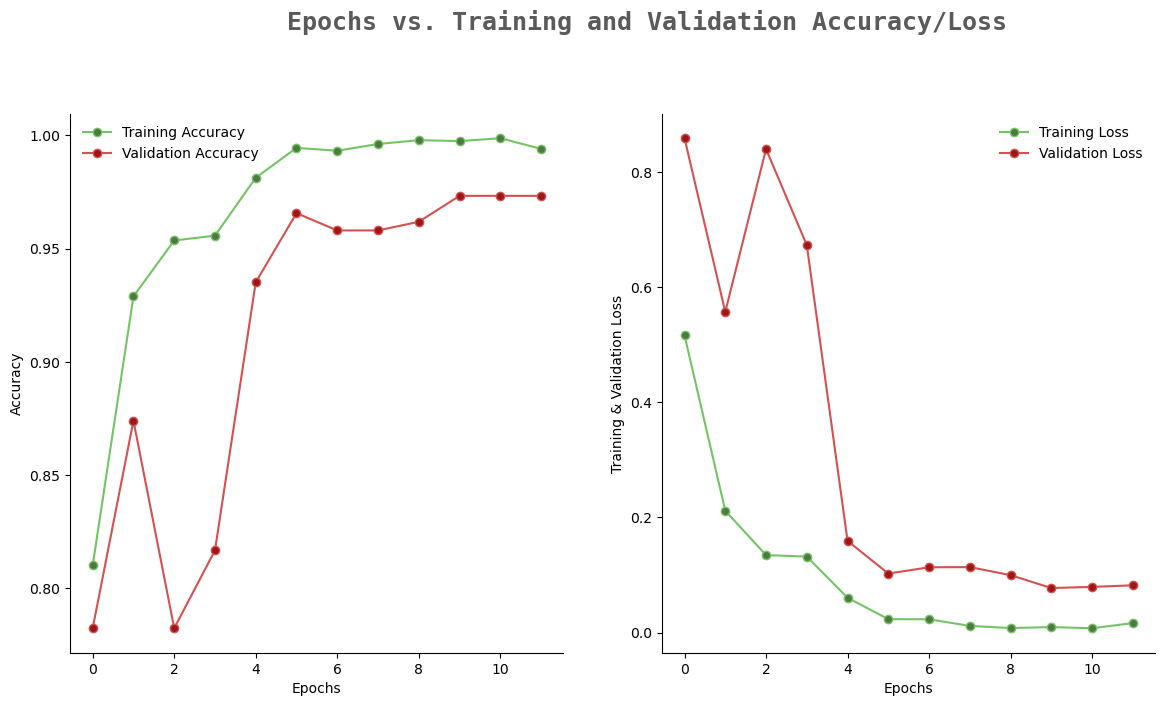

In [22]:
filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o', markerfacecolor=colors_green[2], color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o', markerfacecolor=colors_red[2], color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o', markerfacecolor=colors_green[2], color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o', markerfacecolor=colors_red[2], color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

---

# Prediction

I've used the *argmax function* as each row from the prediction array contains four values for the respective labels. The **maximum** value which is in each row depicts the predicted output out of the 4 possible outcomes.<br>
So with *argmax*, I'm able to find out the index associated with the predicted outcome.

In [6]:
## load tensorflow model
model = tf.keras.models.load_model('../saves/models/effnet_model.h5')

In [23]:
X_test = np.load('../saves/data/x_test.npy')
y_test = np.load('../saves/data/y_test.npy')

In [24]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

21/21 [==============================] - 8s 335ms/step


---

# Evaluation

In this, <br>
0 - Glioma Tumor<br>
1 - No Tumor<br>
2 - Meningioma Tumor<br>
3 - Pituitary Tumor<br>

In [25]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       199
           1       0.96      0.99      0.98       108
           2       0.98      0.97      0.98       177
           3       0.99      1.00      1.00       169

    accuracy                           0.98       653
   macro avg       0.98      0.98      0.98       653
weighted avg       0.98      0.98      0.98       653



In [26]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

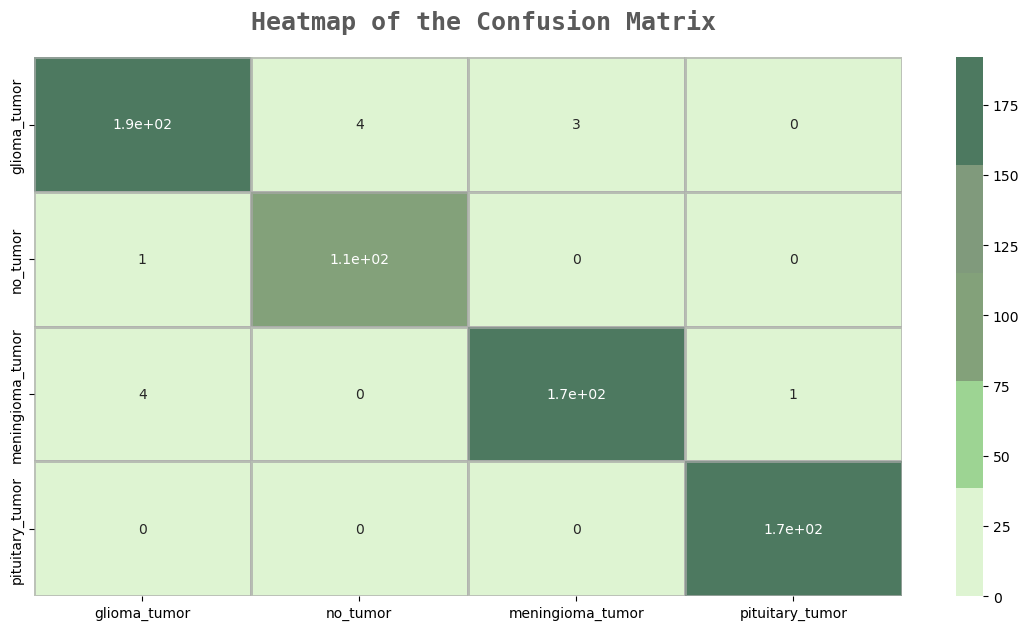

In [27]:
fig,ax=plt.subplots(1,1,figsize=(14,7))

sns.heatmap(confusion_matrix(y_test_new,pred), 
            ax=ax,
            xticklabels=labels, 
            yticklabels=labels, 
            annot=True,
            cmap=colors_green[::-1],
            alpha=0.7,linewidths=2,
            linecolor=colors_dark[3]
           )

fig.text(s='Heatmap of the Confusion Matrix', size=18, fontweight='bold',
             fontname='monospace', color=colors_dark[1], y=0.92, x=0.28, alpha=0.8)

plt.show()

---